# Continuum Current Analytics
I will use this notebook to understand the analytic formulation for the continuum current, with and without the Andreev approximation.

In [243]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.integrate
import scipy.special
import scipy.constants

In [244]:
# set the physical constants
e = scipy.constants.e
h = scipy.constants.h
hbar = scipy.constants.hbar
L_scale = 1e-9 # nm
E_scale = e # eV
m = 0.023*scipy.constants.m_e # InAs

# these constants are used in the functions from the global scope

In [245]:
def calc_delta_k(E,mu):
    k_e = np.sqrt(2*m*(mu + E)*E_scale)/hbar
    k_h = np.sqrt(2*m*(mu - E)*E_scale)/hbar
    return k_e - k_h

def calc_delta_k_Andreev(E,mu):
    return (np.sqrt(2*m*mu*E_scale)/hbar)*(E/mu)

def calc_F(sign,E,chi,Delta,mu,L):
    '''
        Calculates the F function, which the inverse of the transmission function
    '''
    delta_k = calc_delta_k(E,mu)
    return 1 - (Delta*np.cos(0.5*(sign*delta_k*L*L_scale - chi))/E)**2

def calc_F_Andreev(sign,E,chi,Delta,mu,L):
    '''
        Calculates the F function in the Andreev approximation, which the inverse of the transmission function
    '''
    delta_k = calc_delta_k_Andreev(E,mu)
    return 1 - (Delta * np.cos(0.5*(sign*delta_k*L*L_scale - chi))/E)**2

def fermi(E,kT):
    return scipy.special.expit(-E/kT)

def J_integrand(E,chi,Delta,mu,L,kT):
    factor_1 = (2*e/h)*np.abs(np.sqrt(E**2 - Delta**2)/E)
    factor_2 = (1/calc_F(1,E,chi,Delta,mu,L) - 1/calc_F(-1,E,chi,Delta,mu,L))
    factor_3 = fermi(E,kT)
    
    return factor_1*factor_2*factor_3

def J_integrand_Andreev(E,chi,Delta,mu,L,kT):
    factor_1 = (2*e/h)*np.abs(np.sqrt(E**2 - Delta**2)/E)
    factor_2 = (1/calc_F_Andreev(1,E,chi,Delta,mu,L) - 1/calc_F_Andreev(-1,E,chi,Delta,mu,L))
    factor_3 = fermi(E,kT)
    
    return factor_1*factor_2*factor_3 

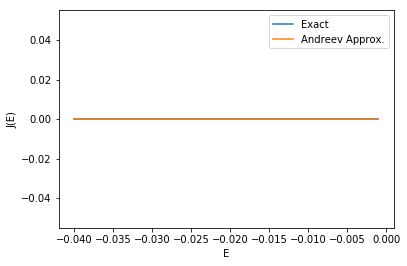

In [299]:
# parameters 
Delta = 1e-3
kT = 1e-5
L = 400
mu = 40e-3

E_vec = np.linspace(-mu,-Delta,1000)
chi = np.pi
chi = 0

J_vec = J_integrand(E_vec,chi,Delta,mu,L,kT)
J_vec_Andreev = J_integrand_Andreev(E_vec,chi,Delta,mu,L,kT)
plt.plot(E_vec,J_vec,label="Exact")
plt.plot(E_vec,J_vec_Andreev,label="Andreev Approx.")
plt.xlabel("E")
plt.ylabel("J(E)")
plt.legend()

In [195]:
chi_vec = np.linspace(0,2*np.pi,100)
L = 500
J_chi_vec_neg = np.array([scipy.integrate.quad(J_integrand,-mu,-Delta*(1.01),args=(chi,Delta,mu,L,kT),limit=100000,epsrel=1e-4,maxp1=100) for chi in chi_vec])
J_chi_vec_pos = np.array([scipy.integrate.quad(J_integrand,Delta*(1.01),mu,args=(chi,Delta,mu,L,kT),limit=100000,epsrel=1e-4,maxp1=100) for chi in chi_vec])
J_chi_vec = J_chi_vec_neg + J_chi_vec_pos

/usr/local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


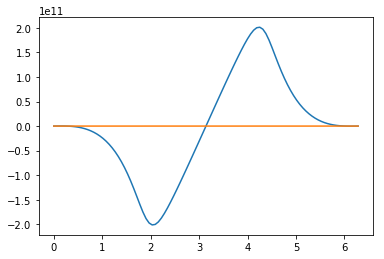

In [196]:
plt.plot(chi_vec,J_chi_vec)

In [305]:
# trying fixed samples integation
chi_vec = np.linspace(np.pi - 0.1,np.pi + 0.1,100)
E_vec_neg = np.linspace(-mu,-Delta,2048 + 1)
E_vec_plus = np.linspace(Delta,mu,2048 + 1)
J_chi_vec = []
L = 550
mu = 40e-3
Delta = 1.0e-3
for chi in chi_vec:
    J_vec_neg = J_integrand(E_vec_neg,chi,Delta,mu,L,kT)
    J_vec_plus = J_integrand(E_vec_plus,chi,Delta,mu,L,kT)
    J_chi_vec.append(scipy.integrate.romb(J_vec_plus) + scipy.integrate.romb(J_vec_neg))

Text(0,0.5,'Continuum Current')

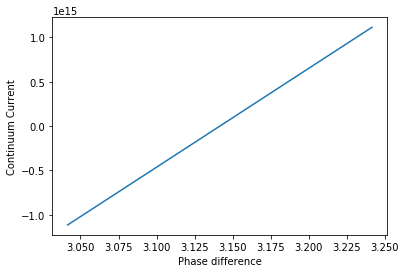

In [306]:
plt.plot(chi_vec,J_chi_vec)
plt.xlabel("Phase difference")
plt.ylabel("Continuum Current")

In [234]:
# 2d map for L dependence
J_chi_L_array = []
L_vec = np.linspace(10,2000,100)

for L in L_vec:
    J_chi_vec = []
    for chi in chi_vec:
        J_vec_neg = J_integrand(E_vec_neg,chi,Delta,mu,L,kT)
        J_vec_plus = J_integrand(E_vec_plus,chi,Delta,mu,L,kT)
        J_chi_vec.append(scipy.integrate.romb(J_vec_plus) + scipy.integrate.romb(J_vec_neg))
    J_chi_L_array.append(J_chi_vec)

Text(0.5,1,'Continuum Current')

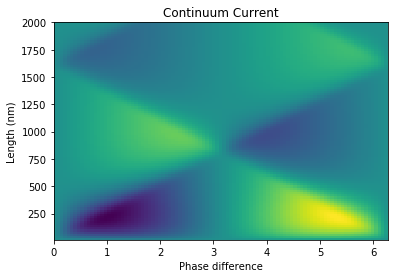

In [241]:
XX,YY = np.meshgrid(chi_vec,L_vec)
plt.pcolor(XX,YY,J_chi_L_array)
plt.xlabel("Phase difference")
plt.ylabel("Length (nm)")
plt.title("Continuum Current")